# **AM 207**: Homework 5

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday April 14th, 2016**

### Note: This homework is only for one week

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW5.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW5.tar.gz or AM207_YOURNAME_HW5.zip


### Have Fun!
_ _ _ _ _

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string

# Problem 1: HMM... I Think Your Text Got Corrupted!

In this problem you should use a Hidden Markov Model to correct typos in a text without using a dictionary. Your data is in two different text files:

* `Shakespeare_correct.txt` contains the words of some sonnets from Shakespeare
* `Shakespeare_typos.txt` contains the same text, but now some of the characters are corrupted

For convenience both text files only contain lower case letters a-z and spaces. 

First build a first order HMM:
* What are the hidden states and what are the observed states?
* What should you do to generate your HMM probability matrices?
* For some of the HMM parameters, you won't have enough training data to get representative probabilities.  For example, some of your probabilites might be 0. You should address this problem by adding a small pseudocount, similar to the motif finding problem from a previous assignment. 
* Implement the Viterbi algorithm and run it on a test portion that contains errors. Show that your Viterbi implementation can improve text of length 100, 500, 1000, and 2000. Note: To do this correctly you would have to withhold the part of the text that you use for testing when you estimate the parameters for you HMM. For the sake of this homework it is ok though to report training error instead of test error. Just be aware that the correction rate you are reporting most likely is a very optimistic estimate. 
* What correction rate do you get?

**Important**: Wikipedia has a nice article on [Viterbi](https://en.wikipedia.org/wiki/Viterbi_algorithm). **Please do not use the python implementation from this article!** (The lecture notebook also has the version from Wikipedia). Using dictionaries for Viterbi is really not intuitive and using numpy is typically faster. The article has very nice pseudo code that should enable you to easily program Viterbi by yourself. Please also refrain for this problem from using any other third party implementations. 

Now for a second order HMM:
By using a second order HMM, you should be able to get a better correction rate. 
* Give an intuitive explanation why a second order HMM should give better results.
* Implement your second order text correction. Hint: If you think a bit about the model you won't even have to change your Viterbi implementation. 
* Compare your correction rates against the first order model for text length of 100 and 500, (you can do 1000 as well if your computer is fast enough). 
* How well would your implementation scale to HMMs of even higher order? 

## Solution
    
We implement first order and second order HMM to correct the typos. 

### First order HMM
Here the hidden states $z_k$ is the estimated (or corrected) letter at location $k$ of the sequence. The observed states $x_k$ is the observed letter at location $k$ of the typo sequence. 

We need to generate the transition matrix $T \in R^{27\times27}$ and the emission matrix $ E \in R^{27\times27}$. Here we work in the unit of letters. There are 60208 letters in the given texts. The matrix is 27 by 27 because there are 26 letters and 1 space. We can calculate $T$ such that $T_{ij} = P(j|i)$, where j and i are the letter is the alphabet or space. j corresponds to the letter at $z_k$, and i corresponds to the letter at $z_{k-1}$.  We simply loop through the sequence of correct letters, look at every consecutive pair of $z_k$ and $z_{k+1}$, and increment the corresponding $T_{ij}$ by 1. 

Similarly, we can generate the emission matrix $E$ by looking at the correct sequence and the typo sequence. Here the matrix is 27 by 27 because there are 26 letters and 1 space. We can calculate $E$ such that $E_{ij} = P(j|i)$, where j and i are the letter is the alphabet or space. j corresponds to the letter at $x_k$, and i corresponds to the letter at $z_k$. For each pair of $z_k$ and $x_k$, we increment of the corresponding element  $E_{ij}$ by 1. 

Following the instruction, we add a pseudocount of 0.1 to all elements of $E$ and $T$. Finally, we normalize the rows of E and T such that $\sum_j E_{ij} = 1$ and $\sum_j T_{ij} = 1$.  

Next we implement of viterbi algorithm using numpy arrays. For implmentation details please refer to the attached code. The core recursive step is 

$$ V_t(z_k) =  \max_{z_{k-1}} T_{kj} \times V_{t-1}(z_{k}) \times E_{x_k,z_k} $$, 
where $V_t(z_k)$ is the maximum probability of the hidden state is $z_k$ at time step t. To avoid numerical instability, we work in log scale instead. 

To avoid re-computing $T$ and $E$ for each test case, we report training error which is based on the same T and E matrix. We find the typo substring usually has correction rate of around 0.8. We use viterbi implementation to predict the hidden states and look at the correction rate of the corrected text. Here we define the correction rate as:

$$ R_{correction} = \frac{typo\_error - corrected\_error}{typo\_error} = \frac{corrected\_correct\_rate - typo\_correct\_rate}{1-typo\_correct\_rate}$$

For fair comparison, we run the same algorithm on several segements of equal length with random starting position to estimate $R_{correction}$ mean and standard deviation for different length. The plots of 1st order HMM and 2nd order HMM (using same typo input string) results are attached with the code. The results of 1st order HMM are:

$$ length = 100 , \ \ \ mean(R)=0.598, \ \ \ std(R)= 0.165$$
$$ length = 500 , \ \ \ mean(R)=0.631, \ \ \ std(R)=0.061$$
$$ length = 1000 , \ \ \ mean(R)=0.627, \ \ \ std(R)=0.047$$
$$ length = 2000 , \ \ \ mean(R)=0.628, \ \ \ std(R)=0.034$$

Overall, the correction rate of 1st order HMM is around $63\%$.

### Second order HMM

Intuitively we expect second order HMM to yield better correction rate because we are using the previous 2 states to predict the current state. In English spelling there are roots that make prediction more accurate. Words of length 3 or shorter may also benefit. For instance, after seeing 'is', it's likely to be followed by a space ' '. After seeing 'ar', it maybe more likely to see the next letter being 'e'. However, we need to make sure that the training set is large enough since there are much more states. 

Please refer to the attached implmentation below. Here we use the same viterbi implmentation to do 1st order and 2nd order HMM. The function is identical. The only differences are the input states and probability matrices $T$ and $E$. Here the transition matrix $T$ and emission matrix $E$ are of size $27^2 \times 27^2$. We formulate every possible pair and then update the appropriate entries by looping through the correct and typo sequences. Note that the second order HMM have more hidden states and hence is more computationally intensive. For details of how to generat $T$ and $E$, please refer to the attached code. Note that it is possible to reduce memory usage by using sparse matrices. We know most elements of the transition probability $T$ are zero if the second letter of ${z_{k-1},z_k}$is different from the first letter of ${z_{k},z_{k+1}}$. (i.e $T: P(ab|cd) = 0$)

My implementation of viterbi will remain the same when scaling to even higher HMM. However, the computational cost will become infeasible since the number of states will grow as the power of the order. If we want to implement higher order models then we need to use sparse matrices and make simplifications, possibly ruling out infeasible states.  

For fair comparison, we run the same algorithm on several segements of equal length with random starting position to estimate $R_{correction}$ mean and standard deviation for different length. The plots of 1st order HMM and 2nd order HMM (using same typo input string) results are attached with the code. The results of 2nd order HMM are:

$$ length = 100 , \ \ \ mean(R)=0.972, \ \ \ std(R)=0.019$$
$$ length = 500 , \ \ \ mean(R)=0.974, \ \ \ std(R)=0.0079$$
$$ length = 1000 , \ \ \ mean(R)=0.975, \ \ \ std(R)=0.0054$$
$$ length = 2000 , \ \ \ mean(R)=0.974, \ \ \ std(R)=0.0041$$

Overall, the correction rate of 2nd order HMM is around $97\%$.


In [11]:
#load in word sequences
with open('Shakespeare_correct.txt', 'r') as myfile:
    data = myfile.read() 
correct_l_len = len(data)
print 'length of correct letter is,', correct_l_len
correct_letters = data


with open('Shakespeare_typos.txt', 'r') as myfile:
    data=myfile.read()  
typo_len = len(data)
typo_letters = data
print 'length of typo letter is', typo_len


#function to calculate transition matrix of letters and spaces
def calc_1st_trans_prob(s1 = correct_letters):
    #initialize 
    ref_string = ' abcdefghijklmnopqrstuvwxyz'
    T = np.zeros((27,27),dtype = 'float')
    for i in range(1,len(s1)):
        row_zkm1 = ref_string.index(s1[i-1])
        col_zk = ref_string.index(s1[i])
        T[row_zkm1,col_zk] +=1
        
    #normalize and add pseudocount
    pseudocount = 0.1
    T += pseudocount
    
    for i in range(T.shape[0]):
        T[i,:] = T[i,:] / np.sum(T[i,:])
    
    return T

#calculate 2nd order transition matrix of letters and spaces
def calc_2nd_trans_prob(s1 = correct_letters):
    #initialize 
    ref_string = ' abcdefghijklmnopqrstuvwxyz'
    T = np.zeros((27**2,27**2),dtype = 'float')
    for i in range(2,len(s1)):
        row_zkm1_zkm2 = ref_string.index(s1[i-2]) * 27 + ref_string.index(s1[i-1])
        col_zk_zkm1 = ref_string.index(s1[i-1])*27 + ref_string.index(s1[i])
        T[row_zkm1_zkm2,col_zk_zkm1] +=1
        
    #normalize and add pseudocount
    pseudocount = 0.1
    T += pseudocount
    
    for i in range(T.shape[0]):
        T[i,:] = T[i,:] / np.sum(T[i,:])
    
    return T

def generate_2nd_HMM_states():
    states = ' abcdefghijklmnopqrstuvwxyz'
    hidden_states = [None] * (27**2)
    for i in range(len(states)):
        for j in range(len(states)):
            hidden_states[i*27 + j] = states[i] + states[j]
    

    return hidden_states

#function to generate second order observation inputs
def generate_2nd_HMM_obs(obs):
    obs_2nd_order = [None] * (len(obs)-1)
    for i in range(len(obs)-1):
        obs_2nd_order[i] = obs[i] + obs[i+1]

    return obs_2nd_order

#function to calculate emission probability matrix of letters and spaces
def calc_emission_prob(s1 = correct_letters, s2 = typo_letters):
    #initialize 
    ref_string = ' abcdefghijklmnopqrstuvwxyz'
    E = np.zeros((27,27),dtype = 'float')
    for i in range(0,len(s1)):
        row_zk = ref_string.index(s1[i])
        col_xk = ref_string.index(s2[i])
        E[row_zk,col_xk] +=1
        
    #normalize and add pseudocount
    pseudocount = 0.1
    E += pseudocount
    
    for i in range(E.shape[0]):
        E[i,:] = E[i,:] / np.sum(E[i,:])
    
    return E

#function to calculate emission probability matrix of letters and spaces
def calc_2nd_emission_prob(s1 = correct_letters, s2 = typo_letters):
    #initialize 
    ref_string = ' abcdefghijklmnopqrstuvwxyz'
    E = np.zeros((27**2,27**2),dtype = 'float')
    for i in range(1,len(s1)):
        row_zkzkm1 = ref_string.index(s1[i-1])*27 + ref_string.index(s1[i])
        col_xkxkm1 = ref_string.index(s2[i-1])*27 + ref_string.index(s2[i])
        E[row_zkzkm1,col_xkxkm1] +=1
        
    #normalize and add pseudocount
    pseudocount = 0.1
    E += pseudocount
    
    for i in range(E.shape[0]):
        E[i,:] = E[i,:] / np.sum(E[i,:])
    
    return E

#calculate correction rate
def calc_correction_rate(ref_list,typo_list,corrected_list):
    
    typo_match_rate = calc_match_rate(ref_list,typo_list)
    corr_match_rate = calc_match_rate(ref_list,corrected_list)
    
    return (corr_match_rate - typo_match_rate) / (1 - typo_match_rate)

#calculate match rate
def calc_match_rate(list_a,list_b):
    num_words = len(list_a)
    num_correct = 0;
    for i in range(num_words):
        if list_a[i] == list_b[i]:
            num_correct += 1

    return (num_correct + 0.0) / (num_words) +0.0
    
#numpy viterbi implementation:
def viterbi(obs, states, start_p, trans_p, emit_p):
    #initialize:
    #print 'viterbi starts...\n'
    len_obs = len(obs)                  #length of observation test string 
    num_states = len(states)     #number of states, here 27 or 27**2
    V = np.zeros((len_obs,num_states),dtype = 'float') #log probabilities
    path = np.zeros((len_obs,num_states),dtype = 'int') -1
    
    #initialize base case
    V[0,:] = np.log(start_p) + np.log(emit_p[:,states.index(obs[0])].transpose())
    
    #run viterbi for t>0 
    for t in range(1,len(obs)):
        log_emit_prob = np.log(emit_p[:,states.index(obs[t])].transpose())
        
        for (indz, z) in enumerate(states):
            log_prob_vec = V[t-1,:] + np.log(trans_p[:,indz].transpose()) + log_emit_prob[indz]
            V[t,indz] = np.max(log_prob_vec)
            path[t-1,indz] = np.argmax(log_prob_vec)     
    
    #find best solution based on IC
    best_ind = np.argmax(V[t,:])
    path[t,best_ind] = best_ind
    best_log_prob = V[t,best_ind]
    best_path = states[best_ind]
    
    #back track to find best path
    col_ind = best_ind
    for i in range(len(obs)-2,-1,-1):
        col_ind = path[i,col_ind]
        best_path += states[col_ind]
    
    #reverse best_path
    best_path = best_path[::-1]

    #return solution
    return best_log_prob, best_path

#driver script
if __name__ == '__main__':
    
    print 'setting up comparison sequences ... '
    #define correction length vector
    correct_len_vec = [100,500,1000,2000]
    repeat = 200
    
    
    start_ind_mat = np.zeros((len(correct_len_vec),repeat),dtype = 'int')
    #initialize segment starting position
    for i in range(len(correct_len_vec)):
        for j in range(repeat):
            start_ind_mat[i,j] = np.random.randint(1,correct_l_len-correct_len_vec[i])
    
    ######### 1st order HMM ######################################################################
    print '1st order HMM starts ...\n'
    
    #generate 1st order transition and emission matrices
    T_1st = calc_1st_trans_prob()
    E_1st = calc_emission_prob()
    
    states = list(' abcdefghijklmnopqrstuvwxyz')
    
    start_p = np.ones(len(states),dtype = 'float')
    correct_rate_mat_1st = np.zeros(start_ind_mat.shape,dtype ='float')
    
    for i in range(start_ind_mat.shape[0]):
        for j in range(start_ind_mat.shape[1]):
            typo_string = typo_letters[start_ind_mat[i,j]:(start_ind_mat[i,j]+correct_len_vec[i])]
            correct_string = correct_letters[start_ind_mat[i,j]:(start_ind_mat[i,j]+correct_len_vec[i])]
            best_log_prob, best_path = viterbi(typo_string,states,start_p,T_1st,E_1st)
            correct_rate_mat_1st[i,j] = calc_correction_rate(correct_string,typo_string,best_path)
    #print correct_rate_mat_1st
    
    correct_1st_mean_rate_vec = np.mean(correct_rate_mat_1st,axis =1)
    correct_1st_std_rate_vec = np.std(correct_rate_mat_1st,axis =1)
       
    #2nd order HMM
    #print generate_2nd_HMM_states()
    
    print '\n2nd order HMM starts ...'
    correct_rate_mat_2nd = np.zeros(start_ind_mat.shape,dtype ='float')
    states = generate_2nd_HMM_states()
    correct_rate_mat_2nd = np.zeros(start_ind_mat.shape,dtype ='float')
    start_p = np.ones(len(emission_states),dtype = 'float')
    
    #generate 2nd order transition and emission matrices
    T_2nd = calc_2nd_trans_prob()
    E_2nd = calc_2nd_emission_prob()
    
    for i in range(start_ind_mat.shape[0]):
        for j in range(start_ind_mat.shape[1]):
            typo_string = generate_2nd_HMM_obs(typo_letters[(start_ind_mat[i,j]-1):((start_ind_mat[i,j])+correct_len_vec[i])])
            correct_string = correct_letters[start_ind_mat[i,j]:(start_ind_mat[i,j]+correct_len_vec[i])]
            best_log_prob, best_path = viterbi(typo_string,states,start_p,T_2nd,E_2nd)
            best_path = best_path[0::2]
            correct_rate_mat_2nd[i,j] = calc_correction_rate(correct_string,typo_string,best_path)
            
    #print correct_rate_mat_2nd
    
    correct_2nd_mean_rate_vec = np.mean(correct_rate_mat_2nd,axis =1)
    correct_2nd_std_rate_vec = np.std(correct_rate_mat_2nd,axis =1)



length of correct letter is, 60208
length of typo letter is 60208
setting up comparison sequences ... 
1st order HMM starts ...


2nd order HMM starts ...


[ 0.59807526  0.63061402  0.62674205  0.62789143]
[ 0.16451171  0.06140456  0.04706334  0.03379084]
[ 0.972      0.97385    0.97482    0.9741325]
[ 0.01910497  0.00787385  0.00548339  0.00407599]


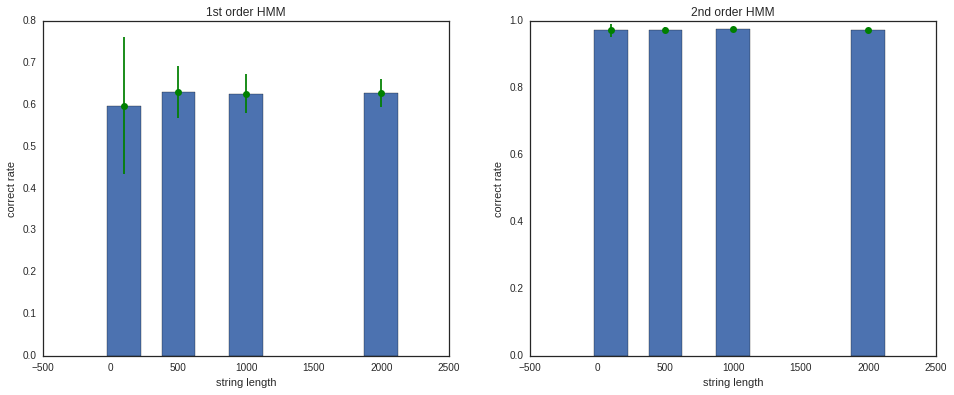

In [14]:
#display results
fig = plt.figure(figsize = (16,6))
draw_w = 250

#1st oder HMM
plt.subplot(1,2,1)
plt.title('1st order HMM')
plt.xlabel('string length')
plt.ylabel('correct rate')
plt.bar(np.array(correct_len_vec)-draw_w/2,correct_1st_mean_rate_vec,width = draw_w)
plt.errorbar(correct_len_vec,correct_1st_mean_rate_vec,yerr = correct_1st_std_rate_vec,fmt = 'o',color ='green')

print correct_1st_mean_rate_vec
print correct_1st_std_rate_vec

#2nd order HMM
plt.subplot(1,2,2)
plt.title('2nd order HMM')
plt.xlabel('string length')
plt.ylabel('correct rate')
plt.bar(np.array(correct_len_vec)-draw_w/2,correct_2nd_mean_rate_vec,width = draw_w)
plt.errorbar(correct_len_vec,correct_2nd_mean_rate_vec,yerr = correct_2nd_std_rate_vec,fmt = 'o',color ='green')

print correct_2nd_mean_rate_vec
print correct_2nd_std_rate_vec

# Extra Problem 2: Final Project Review
    
You will be contacted shortly by a TF to meet and discuss your final project proposal. Be sure to take advantage of this feedback option. Review meetings should be scheduled within the week from April 11-15. 